# Introduction 

## Dataset Details

- UrbanSound8K was extended by adding 900 gunshot files to it. 
  - "UrbanSound8K.csv" was modified accordingly.
  - "CombinedUrbanSound8K-modified.csv" was created for the latest version of the dataset.

- Moreover, UrbanSound8K was modified for binary classification with new classes:
  - no_gun_shot (7929 files, which is 4 times compared to the other class.)
  - gun_shot (1673)
  - Total files amount to 9602.

- Lastly, the number of folds was increased from 10 to 25.



# Retriving and Visualizing the Dataset

In [180]:
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import numpy as np
import sys
import os

# for visualization
import scipy
from scipy import signal
import IPython.display as ipd

## Get the classes
Reading all class names along with their numeric labels from csv file.

In [181]:
import pandas as pd
import numpy as np

# Set up directory paths
dataset_dir = r".\Fold_increased"
metadata_csv = r".\Fold_increased\metadata\CombinedUrbanSound8K-modified.csv"
audio_dir = r".\Fold_increased\audio"

# Read the metadata CSV into a DataFrame
metadata = pd.read_csv(metadata_csv)

# Convert the metadata DataFrame to a DataFrame named 'df'
df = pd.DataFrame(metadata)

# Extract unique classes from the DataFrame
classes = df[['classID', 'class']].values.tolist()

# Format each class ID and class name into a string format and get unique combinations
classes = set(['{} {}'.format(c[0], c[1]) for c in classes])

# Split each unique combination into an array format
classes = np.array([c.split(' ') for c in classes])

# Convert the array of class IDs and names into a dictionary for easier reference
classes_dict = {k: v for k, v in classes}

# Print out the dictionary of unique classes
print(classes_dict)


{'1': 'gun_shot', '0': 'no_gun_shot'}


## Exploring Dataset

              count
class              
gun_shot     1674.0
no_gun_shot  7930.0

Total examples = 9604.0
Ratio (gunshot//no_gunshot) = 0.2110970996216898


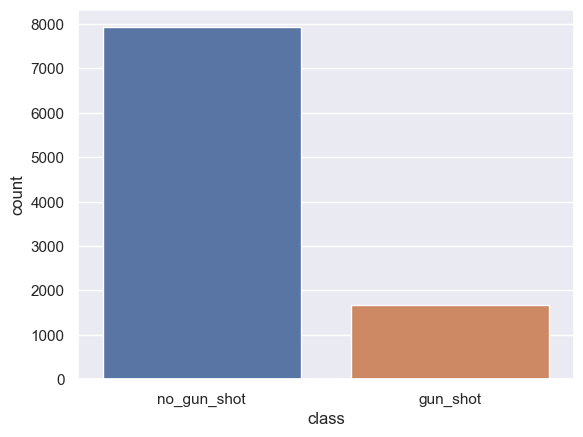

In [182]:
import seaborn as sns

class_count = pd.DataFrame(df.groupby("class").describe()["fsID"]["count"])
print(class_count)
print()
num_gunshots = class_count["count"][0]
num_no_gunshots = class_count["count"][1]
print("Total examples = " + str(num_no_gunshots+num_gunshots))
print("Ratio (gunshot//no_gunshot) = " + str(num_gunshots/num_no_gunshots))

sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=df)

## Visualizing Dataset

In [183]:
from tkinter import*
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

from tkinter import filedialog
selected_files = filedialog.askopenfilename(multiple=True)

%gui tk

<class 'numpy.ndarray'> <class 'int'>
(176400,) 44100


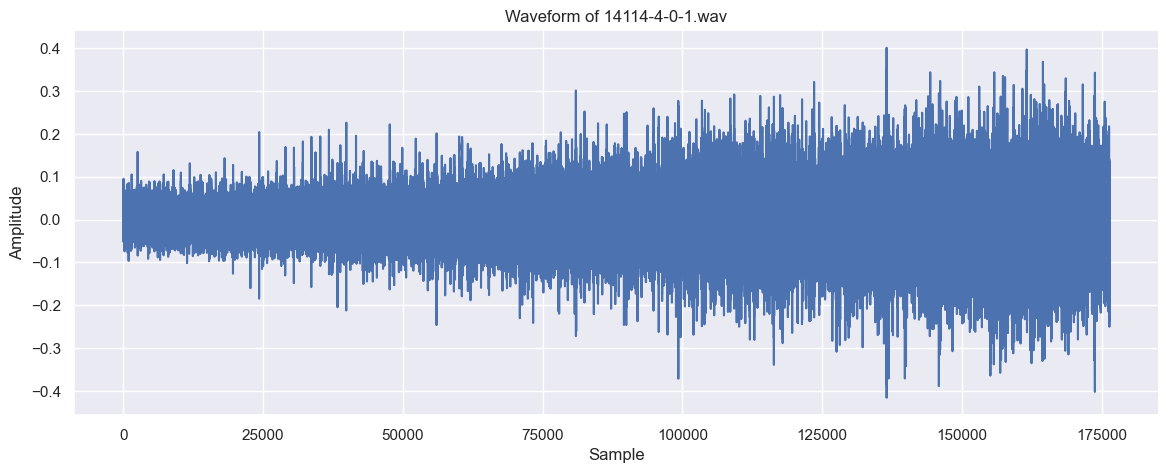

In [184]:
from librosa import display
for file in selected_files:
    # Load audio file using librosa
    x, sr = librosa.load(file, sr=44100)
    
    # Print types and shape of loaded audio for debugging
    print(type(x), type(sr))
    print(x.shape, sr)
    
    # Plotting the waveform using matplotlib
    plt.figure(figsize=(14, 5))
    plt.plot(x)
    plt.title(f"Waveform of {file.split('/')[-1]}")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()
    

# Extracting Features of Audio Files

In [185]:
import struct

class WavFileHelper():
    
    def read_file_properties(self, filename):
        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

In [186]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display

wavfilehelper = WavFileHelper()

audiodata = []
for index, row in metadata.iterrows():
    file_name = os.path.join(audio_dir, 'fold'+str(row["fold"])+'\\', str(row["file_name"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

## Checking Audio Properties

2    0.923053
1    0.076947
Name: num_channels, dtype: float64


<Axes: >

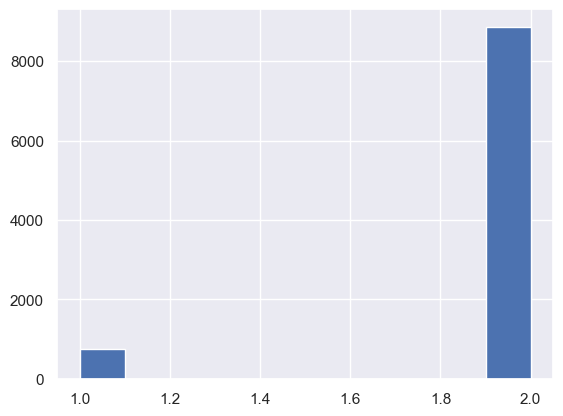

In [187]:
print(audiodf.num_channels.value_counts(normalize=True))
audiodf.num_channels.hist()

16    0.690337
24    0.286651
32    0.017597
8     0.004477
4     0.000937
Name: bit_depth, dtype: float64


<Axes: >

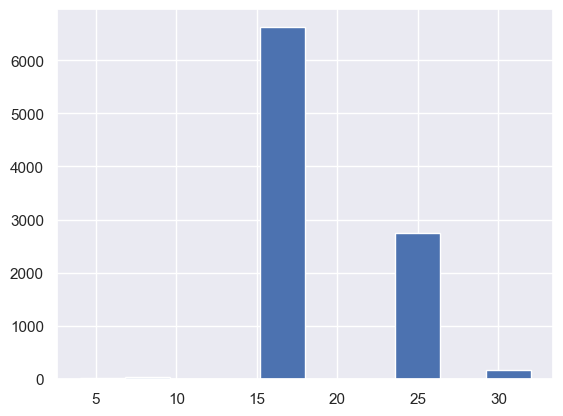

In [188]:
print(audiodf.bit_depth.value_counts(normalize=True))
audiodf.bit_depth.hist()

44100     0.581633
48000     0.328821
96000     0.063515
24000     0.008538
16000     0.004686
22050     0.004581
11025     0.004061
192000    0.001770
8000      0.001249
11024     0.000729
32000     0.000416
Name: sample_rate, dtype: float64


<Axes: >

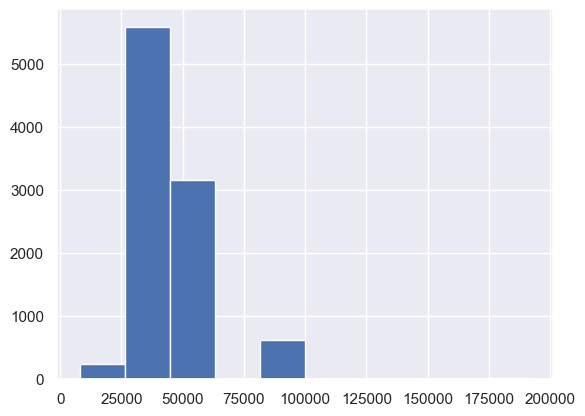

In [189]:
print(audiodf.sample_rate.value_counts(normalize=True))
audiodf.sample_rate.hist()

In [198]:
audiodata[0]

(2, 44100, 24)

## Preprocessing with Librosa for better results

In [199]:
import librosa
import numpy as np

def extract_features(file_path):
    """
    Extract MFCC features from an audio file.
    
    Parameters:
    - file_path (str): Path to the audio file.
    
    Returns:
    - np.ndarray: Extracted MFCC features (mean across time).
    """
    try:
        # Load audio file and extract MFCC features
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')  # Use original sample rate
        #mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40, n_mels=40, n_fft=1103)#, fmax=8000, n_fft=1536, hop_length=512
        
        mfccs_mean = np.mean(mfccs.T, axis=0)
        
    except Exception as e:
        print(f"Error encountered while processing file: {file_path}. Error: {e}")
        return None
    
    return mfccs_mean


In [200]:
def extract_features_arr(audio_arr, sample_rate):
   
    mfccs = librosa.feature.mfcc(y=audio_arr, sr=sample_rate, n_mfcc=40)
    mfccsscaled = np.mean(mfccs.T,axis=0)
     
    return mfccsscaled

In [203]:
import os
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

# Assuming audio_dir is a global variable
audio_dir = "D:\\iot_project\\Fold_increased\\audio"

class SoundPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        features = []

        # Iterate through each sound file and extract features
        for _, row in X.iterrows():
            # Extract the file name from the row
            file_name = str(row["file_name"])
            
            # Construct the file path dynamically based on whether the file name contains a space
            if ' ' in file_name:
                # Remove double quotes from the file name if present
                file_name = file_name.replace('"', '')
                
            file_path = os.path.join(audio_dir, 'fold' + str(row["fold"])+'\\', file_name)
            class_label = row["classID"]
            
            # Extract features using the defined function
            data = extract_features(file_path)
            
            if data is not None:
                features.append([data, class_label])
            else:
                print(f"Failed to extract features for file: {file_path}")
        
        # Convert to a DataFrame
        features_df = pd.DataFrame(features, columns=['feature', 'class_label'])
        X = np.array(features_df.feature.tolist())
        #y = np.array(features_df.class_label.tolist())
        
        return features_df


In [204]:
sound_preprocessor = SoundPreprocessor()
featuresdf = sound_preprocessor.transform(metadata)
print('Finished feature extraction from', len(featuresdf), 'files')

Finished feature extraction from 9604 files


In [205]:
featuresdf["feature"][0].shape

(40,)

## Saving & Loading Features Dataframe 

In [206]:
# Import necessary libraries
import pandas as pd

# Assuming featuresdf is your DataFrame containing extracted features and labels

# ... (Your previous code for defining featuresdf ...)

# Convert 'feature' column elements to strings (or appropriate format) to address the warning
# This is a hypothetical example; adjust based on your actual data structure and requirements
#featuresdf['feature'] = featuresdf['feature'].astype(str)

# Create or open an HDF5 file in write mode
with pd.HDFStore('Backups//dataframes_backup.h5', 'w') as backup:
    # Store the featuresdf DataFrame in the HDF5 file under the key 'featuresdf'
    backup["featuresdf"] = featuresdf

# (Optional) Verify the contents of the HDF5 file
# Open the HDF5 file in read mode
with pd.HDFStore('Backups//dataframes_backup.h5', 'r') as backup:
    # Display the keys (i.e., stored objects) within the HDF5 file
    print(backup.keys())

# End of the code


['/featuresdf']


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27668\2485927883.py:15: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['feature'], dtype='object')]

  backup["featuresdf"] = featuresdf


In [207]:
# using HDFStore for high speed data reading
backup = pd.HDFStore('Backups//dataframes_backup.h5', 'r+')

# uncomment to store featuresdf again
#backup["featuresdf"] = featuresdf
#backup["featuresdf_custom"] = featuresdf_custom

# loading from featuresdf from .h5 file
featuresdf = backup["featuresdf"]
backup.close()

# Splitting Dataset, Defining Model, Training & Evaluation

## One-hot Encoding and Splitting of Dataset

In [208]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
print(X.shape)
print(y.shape)

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=.01, random_state = 42)

(9604, 40)
(9604,)


## Defining CNN Model

In [209]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
#from keras.utils import np_utils
from sklearn import metrics 

In [210]:
num_rows = 4
num_columns = 10
num_channels = 1

In [211]:
x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

In [212]:
# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding="same", input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='sigmoid'))

In [213]:
"""
Use this cell to train data on specific set of files only 

"""
# # Set the path to the full UrbanSound dataset 
features_custom = []

path_to_files = r"D:\iot_project\Fold_increased\Yeni klasör"
# Iterate through each sound file and extract the features 
for file in os.listdir(path_to_files):
    file_name = os.path.join(path_to_files, file)
    class_label = 1
    data = extract_features(file_name)
    features_custom.append([data, class_label])

# # Convert into a Panda dataframe 
featuresdf_custom = pd.DataFrame(features_custom, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf_custom), ' files')

# del featuresdf
featuresdf2 = featuresdf_custom

Finished feature extraction from  2  files


In [214]:
featuresdf2

,feature,class_label
0,"[-233.41153, 53.07357, -2.2140467, 14.897002, ...",1
1,"[-193.68588, 58.91609, -7.1567407, 17.725811, ...",1


In [215]:
# Update featuresdf with data from featuresdf2
featuresdf.update(featuresdf2)

# Now, featuresdf contains the updated rows where data from featuresdf2 overwrote existing rows in featuresdf.


## Model Compilation

In [216]:
# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 4, 10, 16)         80        
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 4, 10, 16)         0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 4, 10, 16)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 10, 32)         2080      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 4, 10, 32)         0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 4, 10, 32)        

4/4 [==============================] - 1s 8ms/step - loss: 0.7194 - accuracy: 0.1959
Pre-training accuracy: 19.5876%


## Training & Saving Checkpoints with Best Validation Accuracy

In [217]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 50
num_batch_size = 50

checkpointer = ModelCheckpoint(filepath='best_weights_temp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
190/191 [============================>.] - ETA: 0s - loss: 0.4443 - accuracy: 0.8205
Epoch 1: val_loss improved from inf to 0.38979, saving model to best_weights_temp.hdf5


C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


191/191 [==============================] - 7s 25ms/step - loss: 0.4440 - accuracy: 0.8207 - val_loss: 0.3898 - val_accuracy: 0.8041
Epoch 2/50
189/191 [============================>.] - ETA: 0s - loss: 0.3812 - accuracy: 0.8403
Epoch 2: val_loss improved from 0.38979 to 0.29617, saving model to best_weights_temp.hdf5
191/191 [==============================] - 4s 23ms/step - loss: 0.3805 - accuracy: 0.8404 - val_loss: 0.2962 - val_accuracy: 0.8454
Epoch 3/50
189/191 [============================>.] - ETA: 0s - loss: 0.3312 - accuracy: 0.8679
Epoch 3: val_loss improved from 0.29617 to 0.28645, saving model to best_weights_temp.hdf5
191/191 [==============================] - 4s 23ms/step - loss: 0.3312 - accuracy: 0.8680 - val_loss: 0.2865 - val_accuracy: 0.9485
Epoch 4/50
191/191 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8843
Epoch 4: val_loss improved from 0.28645 to 0.22826, saving model to best_weights_temp.hdf5
191/191 [==============================] - 

## Evaluation

In [218]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2f}".format(score[1] * 100) + "%")

score = model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: {0:.2f}".format(score[1] * 100) + "%")

Training Accuracy: 91.57%
Test Accuracy: 86.60%


In [219]:
model.save_weights("Backups//best_weights.hdf5")

In [220]:
# load model


model.load_weights("Backups//best_weights.hdf5")

# Convert the loaded Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to disk
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmpo20flit9\assets


INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmpo20flit9\assets


In [233]:
def predict_class(featuresdf):
    pred_index_tensor=tf.argmax(model.predict(featuresdf.reshape(1, x_train.shape[1], x_train.shape[2], x_train.shape[3])), axis=1)
    pred_index_arr = pred_index_tensor.numpy()
    pred_index = pred_index_arr[0]
    print(pred_index_arr)
    pred_class = classes[pred_index]
    return (pred_index, pred_class)

def index_to_class(index):
    return classes[index]

In [238]:
def predict_class_file(featuresdf):
    pred_index_tensor=tf.argmax(model.predict(featuresdf.reshape(1, x_train.shape[1], x_train.shape[2], x_train.shape[3])), axis=1)
    pred_index_arr = pred_index_tensor.numpy()
    pred_index = pred_index_arr[0]
    print(pred_index_arr)
    pred_class = classes[pred_index-1]
    return (pred_index-1, pred_class)

def index_to_class(index):
    return classes[index]

### Make prediction on test set

In [230]:
# make prediction on test set file
index = int(input("Enter test set file index (total test files are " + str(len(x_test)) + "):\n"))
print()
class_index, class_name = predict_class(x_test[index])
print("Predicted Class: " + str(class_index))
print("Predicted Class Name: " + str(class_name))
print()
# y_test[index] returns a one hot vector
print("Actual Class: " + str(index_to_class(np.argmax(y_test[index]))))


SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (2400814835.py, line 4)

In [228]:
class_index, class_name = predict_class(x_test[50])
classes[class_index]

1/1 [==============================] - 0s 36ms/step
[0]


array(['1', 'gun_shot'], dtype='<U11')

In [239]:
from tkinter import*
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

from tkinter import filedialog
selected_files = filedialog.askopenfilename(multiple=True)

%gui tk

In [241]:
import requests
RECORDING_UPLOAD_URL = 'http://police_station_api_endpoint/upload_recording'
no_of_gunshots = 0
no_of_not_gunshots = 0
for i, file in enumerate(selected_files):
    print("Making prediction on file "+str(i)+": " + file.split("/")[-1])
    print()
    f_features3 = extract_features(file)
    class_index, class_name = predict_class_file(f_features3)
    print("\tPredicted Class Name: " + str(class_name))
    print("__________________________________\n")
    print(class_name)
    if "gun_shot" in class_name:
        no_of_gunshots += 1
        print("gun shott")
         # Upload recording to police station
        with open(file, 'rb') as f:
            files = {'file': f}
            response = requests.post(RECORDING_UPLOAD_URL, files=files)
            
        if response.status_code == 200:
            print("Recording uploaded to police station successfully.")
        else:
            print("Failed to upload recording to police station. Status code: ", response.status_code)
        #web e bağlan
    else:
        no_of_not_gunshots += 1
        
        
print("No. of gun_shots: ", no_of_gunshots)
print("No. of not_gunshots: ", no_of_not_gunshots)

Making prediction on file 0: poligon_2.wav

1/1 [==============================] - 0s 32ms/step
[1]
	Predicted Class Name: ['1' 'gun_shot']
__________________________________

['1' 'gun_shot']
gun shott


ConnectionError: HTTPConnectionPool(host='police_station_api_endpoint', port=80): Max retries exceeded with url: /upload_recording (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000253A5BD52D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [171]:
# use this to play selected files
ipd.Audio(selected_files[0])
# ipd.Audio(data, sample_rate)

## Making Real-time Predictions (For demonstration purposes only)

In [148]:
import queue 
prediction_history = queue.Queue(maxsize=5) 

sample_rate = 44100
threshold = 1 # required number of gunshots, in most recent 5 predictions, 
              # to make final decision
while True:
    gunshot_count = 0
    
    from rcaudio import CoreRecorder
    CR = CoreRecorder(
            time = 4, # How much time to record
            sr = sample_rate # sample rate
            )
    CR.start()
    # CR.stop()
    
    data = [0] * 44100 # initializing the overlapping sound with zeros
    
    while True:
        if not CR.buffer.empty():
            # get every integer from buffer and append in data list
            x = CR.buffer.get()
            data.append(x)
            
            # 4 seconds of recorded sound and 1 second of overlapping sound
            if len(data)//44100 == 5:
                break
                
    data = np.array(data, dtype="float32")
#     print("Making prediction on given array")
    
    # extract features to make prediction
    arr_features = extract_features_arr(data, sample_rate)
#     print(arr_features)
    class_index, class_name = predict_class(arr_features)
#     print("\tPredicted Class: " + str(class_index))
#     print("\tPredicted Class Name: " + str(class_name))
#     print("__________________________________\n")
    
    # overlapping last 1 second
    data = data.tolist()[-44100:] 
    
    prediction_history.put(class_index) # add new result
    
    if prediction_history.full():
        while prediction_history.empty() != True:
            elem = prediction_history.get()
            if elem == "1": # gunshot detected
                gunshot_count += 1
        
        if gunshot_count >= threshold:
            print("Gunshots Detected!")



1/1 [==============================] - 0s 34ms/step


KeyboardInterrupt: 

In [108]:
import queue
import numpy as np
from rcaudio import CoreRecorder  # Assuming this module exists in your environment

# Initialize parameters
sample_rate = 44100
threshold = 1
prediction_history = queue.Queue(maxsize=5)

# Start audio recording for 4 seconds
CR = CoreRecorder(time=4, sr=sample_rate)
CR.start()

data = [0] * 44100  # Initialize with zeros

# Record 5 seconds of audio (4 seconds of new audio and 1 second overlapping)
while True:
    if not CR.buffer.empty():
        x = CR.buffer.get()
        data.append(x)
        
        if len(data) // 44100 == 5:
            break

# Convert data to numpy array
data = np.array(data, dtype="float32")

# Assuming you have the functions extract_features_arr and predict_class defined
# Extract features from the recorded data
arr_features = extract_features_arr(data, sample_rate)

# Make prediction
recognized_sound = recognize_sound(arr_features)  # Assuming this function is defined
print(f"Recognized Sound: {recognized_sound}")

# Overlapping last 1 second of data
data = data.tolist()[-44100:]

# Add prediction to history queue
prediction_history.put(recognized_sound)

# Check if the queue is full
if prediction_history.full():
    gunshot_count = sum(1 for _ in prediction_history.queue if _ == "gunshot")  # Adjust based on your recognition
    
    if gunshot_count >= threshold:
        print("Gunshots Detected!")


NameError: name 'recognize_sound' is not defined